# News Mood Analysis
-----

## Three observation trends based on the data
1. [Tweet Polarity Trend] In the most recent 100 tweets (per each souce/500 tweets in total), @CBS has much positive polarity on its tweets. On the other hand, @FoxNews has relatively negative.
2. [Tweet Frequency Trend] @FoxNews is the most frequent acount as well as @CNN. @nytimes and @BBC are following. @CBS is the least frequent acount and it hardly tweets negative sentence.
3. [Retweet Trend] @FoxNews is the most retweeted no matter whether it is positive or not.

## Usage

1. get an API key from [Twitter](https://developer.twitter.com/)
2. edit config.py
3. run jupytor notebook using following commands
```
$ cd NewsMood
$ jupyter notebook
```

In [1]:
# Dependencies
import csv
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tweepy

# Import API key
from config import consumer_key, consumer_secret, access_token, access_token_secret

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
# consumer_key = "mCENJ4eaaOmh9FsWIGATTPABa"
# consumer_secret = "UQdOndTKbej5YlTTEkBm2VW0PWFilU1t4H3lzEXY8UwcMBXyFK"
# access_token = "2547156404-vQv1CGMeuPRd0gPf0D0stpahOECtvdQ9rgycWR2"
# access_token_secret = "tJNNaDOuSdRiY0lyboE9EfgJc8JdqewkdUjUAl0B4DqaQ"

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

## Function definitions

In [2]:
# Function definition for DF generation from result obj
def generateDF(resultObj, i):
    df = pd.DataFrame({
        "Tweet": resultObj[i]["Tweet"],
        "index": range(0, len(resultObj[i]["Created_at"])),
        "Created_at": resultObj[i]["Created_at"],
        "Compound": resultObj[i]["Compound"],
        "Positive": resultObj[i]["Positive"],
        "Neutral": resultObj[i]["Neutral"],
        "Negative": resultObj[i]["Negative"],
        "Length": resultObj[i]["Tweet_Length"],
        "Retweet_Count": resultObj[i]["Retweet_Count"]
    }).assign(
        User = resultObj[i]["User"]
    )
    df['Created_at'] = pd.to_datetime(df.Created_at)
    df['deltaTime'] = np.max(df['Created_at']) - df['Created_at']
    df['deltaDay'] = pd.to_numeric(df['deltaTime'].apply(lambda x: x.days + x.seconds/(3600*24)))
    df['deltaHour'] = pd.to_numeric(df.deltaTime.apply(lambda x: x.days * 24 + x.seconds/3600))
    return df

# Function definition for graph settings
def setValuestoGraph(xMaxLim, xLabel):
    today = datetime.datetime.now().strftime("%Y-%m-%d")
    plt.title(f"Sentimental Analysis of Media Tweets ({today})")
    plt.ylabel("Tweet Polarity")
    plt.xlabel(xLabel)
    # plt.gca().invert_xaxis()
    plt.xlim(xMaxLim,0)
    plt.ylim(-1,1)

    plt.legend(
        loc="best",
        bbox_to_anchor=(1, 0.5),
        title="Media Sources"
    )
    plt.grid()


## Collect Tweets

In [3]:
# Set target users
target_users = ["@BBC", "@CBS", "@CNN", "@FoxNews", "@nytimes"]

# Set empty list for all sentiment analysis results
all_sentiments = []  

#loop through all users
for target in target_users:
    # Variables for holding sentiments
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []
    tweet_list = []
    length_list = []
    public_tweets = []
    retweet_count_list = []
    created_at = []
    
    # Get 200 tweets each first
    for page in tweepy.Cursor(api.user_timeline, id=target, count=200).pages(1):
        public_tweets += [t._json for t in page] #manual json conversion

    # Loop through tweets till 100 tweets stored into the list
    for tweet in public_tweets:
        # Run Vader Analysis on each tweet if its type is dict 
        if type(tweet) == dict and len(compound_list) < 100:
            
            # Escape uncaught errors in dict
            try:
                tweetStr = tweet['text']
            except Exception as e:
                print("Exception")
            
            # Sentiment analysis
            score = analyzer.polarity_scores(tweetStr)   
            compound = score["compound"]
            pos = score["pos"]
            neu = score["neu"]
            neg = score["neg"]

            # Add each value to the lists
            compound_list.append(compound)
            positive_list.append(pos)
            negative_list.append(neg)
            neutral_list.append(neu)
            tweet_list.append(tweetStr)
            length_list.append(len(tweetStr))
            retweet_count_list.append(tweet['retweet_count'])
            created_at.append(tweet['created_at'])
    
    # End loop for tweets

    # Generate the Sentiments obj and store it to all_sentiments
    sentiment = {
        "User": target,
        "Tweet": tweet_list,    
        "Compound": compound_list,
        "Positive": positive_list,
        "Neutral": neutral_list,
        "Negative": negative_list,
        "Created_at": created_at,
        "Tweet_Length": length_list,
        "Retweet_Count": retweet_count_list,
        "Tweet Count": len(compound_list)
    }
            
    all_sentiments.append(sentiment)

## Generate Resource CSV from DataFrame

In [4]:
# Assign empty list
dflist = []

# Generate DF and store into the list
for i in range(len(all_sentiments)):
    dflist.append(generateDF(all_sentiments, i))

# Merge all DFs
all_df = pd.concat(dflist)
# all_df

# Output
all_df[["User","Created_at","Tweet","Compound","Positive","Neutral","Negative"]].to_csv('resources.csv')

In [5]:
# Show the most positive tweet and negative one
pos = all_df[all_df["Compound"] == max(all_df["Compound"])]
neg = all_df[all_df["Compound"] == min(all_df["Compound"])]

print('The most positive tweet was "' + pos["Tweet"].values[0] + '"')
print('by ' + pos["User"].values[0] + ' created at ' + str(pos["Created_at"].values[0]))
print('which score was ' + str(pos["Compound"].values[0]))
print('---------------')
print('The most negative tweet was "' + neg["Tweet"].values[0] + '"')
print('by ' + neg["User"].values[0] + ' created at ' + str(neg["Created_at"].values[0]))
print('which score was ' + str(neg["Compound"].values[0]))

The most positive tweet was "RT @MomCBS: “I love this job. I love working with these women. I love working in front of the live audience… It’s alive and it’s fun.” - @A…"
by @CBS created at 2018-03-24T22:21:23.000000000
which score was 0.9451
---------------
The most negative tweet was "The officer was killed after he voluntarily exchanged himself for a female hostage during a terrorist attack in Fra… https://t.co/qyzVCzdROk"
by @nytimes created at 2018-03-28T14:15:06.000000000
which score was -0.9231


## the Scatter Plot of Tweet Polarity in Recent 100 Tweets

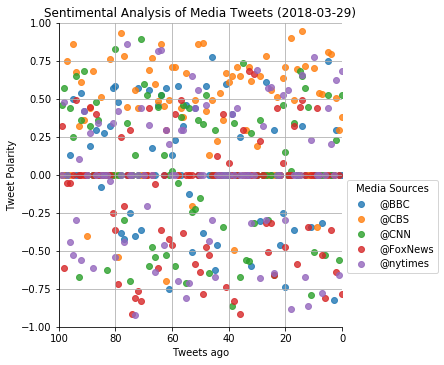

In [6]:
# Set seaborn
## sns.set()
## sns.set_style('white')
sns.lmplot(x='index', y="Compound", hue="User", data=all_df, fit_reg=False, legend=False)
setValuestoGraph(100, "Tweets ago")
plt.savefig("picts/fig1.png")
plt.show()

### the Scatter Plots by Tweeted Date (not required)

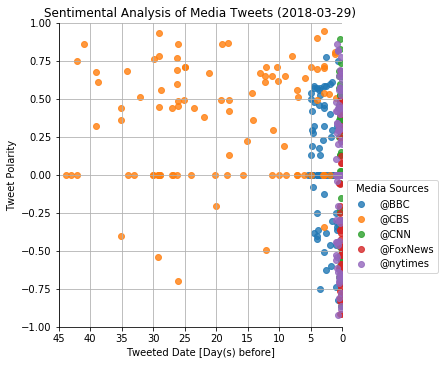

In [7]:
# Set seaborn
sns.lmplot(x='deltaDay', y="Compound", hue="User", data=all_df, fit_reg=False, legend=False)
setValuestoGraph(45, "Tweeted Date [Day(s) before]")
plt.show()

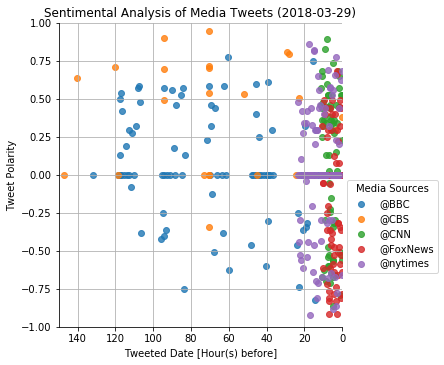

In [8]:
# Set seaborn
sns.lmplot(x='deltaHour', y="Compound", hue="User", data=all_df, fit_reg=False, legend=False)
setValuestoGraph(150, "Tweeted Date [Hour(s) before]")
plt.show()

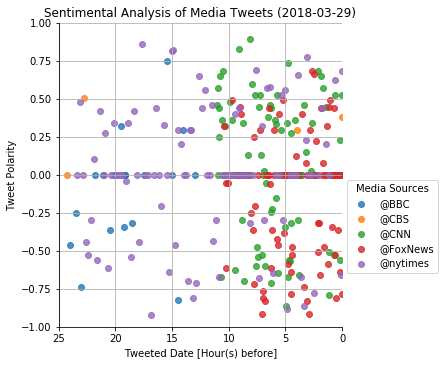

In [9]:
# Set seaborn
sns.lmplot(x='deltaHour', y="Compound", hue="User", data=all_df, fit_reg=False, legend=False)
setValuestoGraph(25, "Tweeted Date [Hour(s) before]")
plt.show()

### the Scatter Plot by Tweet Length (not required)

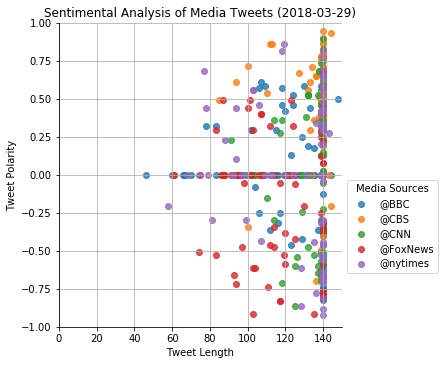

In [10]:
sns.lmplot(x='Length', y="Compound", hue="User", data=all_df, fit_reg=False, legend=False)
setValuestoGraph(150, "Tweet Length")
plt.xlim(0,150)
plt.show()

### the Scatter Plots by Retweet Count (not required)

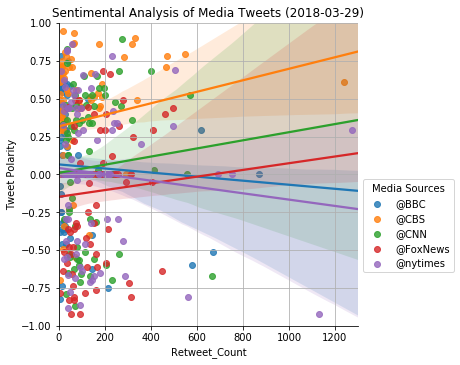

In [11]:
sns.lmplot(x='Retweet_Count', y="Compound", hue="User", data=all_df, legend=False)
setValuestoGraph(1300, "Retweet_Count")
plt.xlim(0,1300)
plt.show()

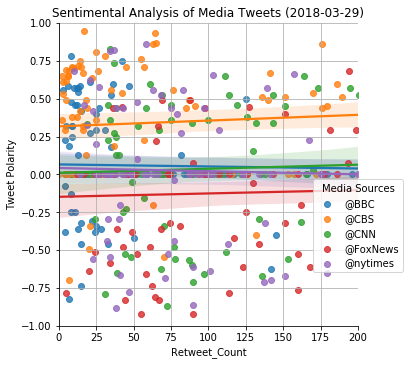

In [12]:

sns.lmplot(x='Retweet_Count', y="Compound", hue="User", data=all_df, legend=False)
setValuestoGraph(200, "Retweet_Count")
plt.xlim(0,200)
plt.show()

### the Bubble Plot by Tweeted Date/Tweet Length (not required)

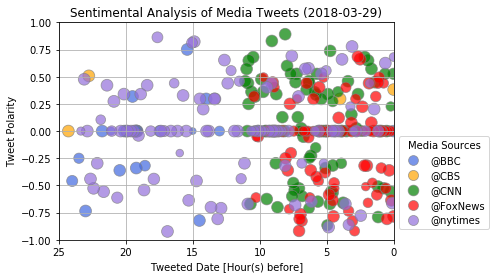

In [13]:
colors = ['royalblue','orange','green','red','mediumpurple']

for x in range(len(target_users)):
#     print(all_df[all_df['User'] == target_users[x]]['Length'])
    plt.scatter(
        all_df[all_df['User'] == target_users[x]]['deltaHour'], 
        all_df[all_df['User'] == target_users[x]]['Compound'], 
        s=1*all_df[all_df['User'] == target_users[x]]['Length'],
        alpha=0.7,
        c=colors[x], 
        edgecolor="gray", 
        label=target_users[x],
        linewidths = 0.8
    )

setValuestoGraph(25, "Tweeted Date [Hour(s) before]")
plt.show()

## the Bar Plot for Overall Tweet Polarity in Recent 100 Tweets

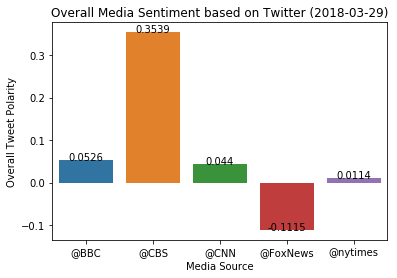

In [14]:
# Create new DF grouped by User then mean the values
meanCompound_df = all_df.groupby('User').mean()[['Compound']]

# set sns
ax = sns.barplot(x=meanCompound_df.index, y="Compound", data=meanCompound_df)

# Title and labels
today = datetime.datetime.now().strftime("%Y-%m-%d")
plt.title(f"Overall Media Sentiment based on Twitter ({today})")
plt.xlabel("Media Source")
plt.ylabel("Overall Tweet Polarity")

for index, row in zip(np.arange(len(meanCompound_df.index)), meanCompound_df['Compound']):
    ax.text(index, row, round(row, 4), ha="center")
plt.savefig("picts/fig2.png")
plt.show()

### the Bar Plots of Ave. Retweeted Count (not required)

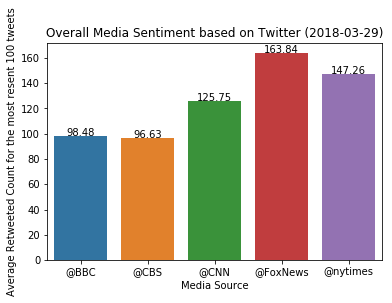

In [15]:
# Create new DF grouped by User then mean the values
meanRetweeted_df = all_df.groupby('User').mean()[['Retweet_Count']]

# Set sns
ax = sns.barplot(x=meanRetweeted_df.index, y="Retweet_Count", data=meanRetweeted_df)

# Title and labels
today = datetime.datetime.now().strftime("%Y-%m-%d")
plt.title(f"Overall Media Sentiment based on Twitter ({today})")
plt.xlabel("Media Source")
plt.ylabel("Average Retweeted Count for the most resent 100 tweets")

for index, row in zip(np.arange(len(meanRetweeted_df.index)), meanRetweeted_df['Retweet_Count']):
    ax.text(index, row, round(row, 4), ha="center")

plt.show()

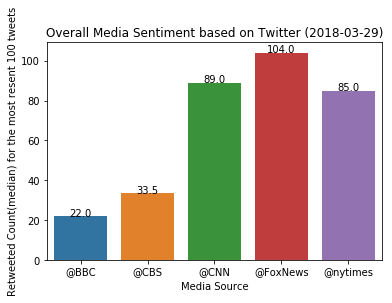

In [16]:
# Create new DF grouped by User the median the values
medianRetweeted_df = all_df.groupby('User').median()[['Retweet_Count']]

# Set sns
ax = sns.barplot(x=medianRetweeted_df.index, y="Retweet_Count", data=medianRetweeted_df)

# Title and labels
today = datetime.datetime.now().strftime("%Y-%m-%d")
plt.title(f"Overall Media Sentiment based on Twitter ({today})")
plt.xlabel("Media Source")
plt.ylabel("Retweeted Count(median) for the most resent 100 tweets")

for index, row in zip(np.arange(len(medianRetweeted_df.index)), medianRetweeted_df['Retweet_Count']):
    ax.text(index, row, round(row, 4), ha="center")

plt.show()

### the Combination Plot between Overall Twitter Polarity and Ave. Retweeted Count (not required)

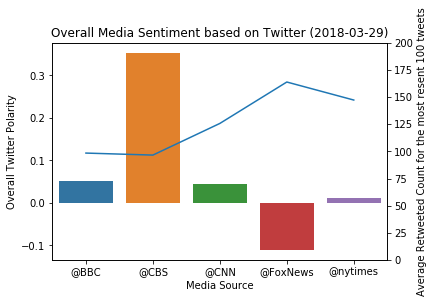

In [17]:
fig = plt.figure()
ax = sns.barplot(x=meanCompound_df.index, y="Compound", data=meanCompound_df)
plt.xlabel("Media Source")
plt.ylabel("Overall Twitter Polarity")


ax2 = ax.twinx()
ax2.plot(meanRetweeted_df)
plt.ylabel("Average Retweeted Count for the most resent 100 tweets")
plt.ylim(0, 200)

# Title and labels
today = datetime.datetime.now().strftime("%Y-%m-%d")
plt.title(f"Overall Media Sentiment based on Twitter ({today})")

# for index, row in zip(np.arange(len(totRetweeted_df.index)), totRetweeted_df['Retweet_Count']):
#     ax.text(index, row, round(row, 4), ha="center")

plt.show()

### the Bar Plot of the Top 50 Negative/Positive Tweet (not required)

In [18]:
Posi_sort_df = all_df.sort_values(by=["Compound"], ascending=False)
Nega_sort_df = all_df.sort_values(by=["Compound"])
pos_neg_df = Posi_sort_df[:50].groupby("User").count()[["Positive"]]
pos_neg_df['Negative'] = Nega_sort_df[:50].groupby("User").count().sort_values(by=["Negative"], ascending=False)["Negative"]

new_df = pd.DataFrame({
    'User': pos_neg_df.index,
    'Positive':list(pos_neg_df['Positive']),
    'Negative':list(pos_neg_df['Negative'])
}).sort_values(by=["User"])
new_df

,Negative,Positive,User
0,5,2,@BBC
1,1,31,@CBS
2,12,7,@CNN
3,18,2,@FoxNews
4,14,8,@nytimes


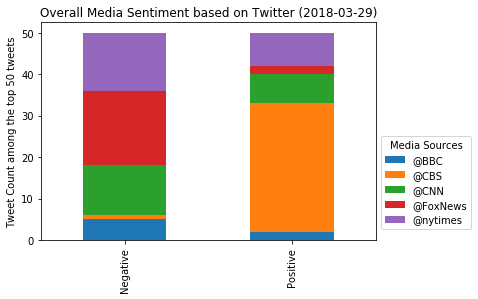

In [19]:
new_df.set_index('User').T.plot(kind='bar', stacked=True)
plt.ylabel("Tweet Count among the top 50 tweets")

# Title and labels
today = datetime.datetime.now().strftime("%Y-%m-%d")
plt.title(f"Overall Media Sentiment based on Twitter ({today})")
plt.legend(
#     loc="best",
    bbox_to_anchor=(1, 0.5),
    title="Media Sources"
)

plt.show()